In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pysus.online_data.CNES import download
from urllib.request import urlopen
import plotly.express as px

In [2]:
# Gráfico do plotly será aberto como uma aba no navegador para melhor visualização
# o valor pode ser alterado para 'firefox'
import plotly.io as pio
pio.renderers.default = 'chrome'

### Processamento de Dados

In [3]:
# Geojson
with urlopen('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-52-mun.json') as response:
    municipios = json.load(response)
    
for feature in municipios['features']:
    feature['id'] = feature['properties']['id']

In [4]:
# Fonte da planilha com os dados do IBGE para os municípios:
# https://github.com/kelvins/Municipios-Brasileiros

df_municipios = pd.read_csv('municipios.csv')

# Selecionando somente os municípios do Estado de Goiás(código 52)
df_municipios = df_municipios.loc[df_municipios.codigo_uf == 52]

# Os códigos do ibge são de 7 dígitos, já os utilizados na planilha do SUS apresentam apenas seis.
df_municipios['codigo_sus'] = df_municipios.codigo_ibge.div(10).astype(int).astype(str)

In [11]:
# Lista dos municípios com o código no formato do sus
list_codigo_municípios_sus = df_municipios.codigo_sus.to_list()

list_municipio_leitos_dict = []
list_leitos_dict_total = []
list_decrescimo = []

# Iniciando um contador para verificar decréscimo na capacidade hospitalar
last_total = 0

for year in range(2020,2023):
    for month in range(1,13):
        # A base ainda não possui dados para o mês de Dezembro de 2022
        if year == 2022 and month == 12:
            pass
        else:
            df = download('LT','GO',year,month)
            leitos_dict = {}

            leitos_dict['Data'] = str(year) + '-' + str(month)
            leitos_dict['QTD Total'] = df.QT_EXIST.sum()
            leitos_dict['QTD SUS'] = df.QT_SUS.sum()
            leitos_dict['QTD Não SUS'] = df.QT_NSUS.sum()
            
            if(last_total > df.QT_EXIST.sum()):
                decrescimo = {}
                decrescimo['Data'] = str(year) + '-' + str(month)
                decrescimo['Valor'] = last_total - df.QT_EXIST.sum()
                list_decrescimo.append(decrescimo)
            
            list_leitos_dict_total.append(leitos_dict)

            for codigo in list_codigo_municípios_sus:
                
                leitos_municipio_dict = {}

                df_municipio_leitos = df.loc[df.CODUFMUN == codigo]
                
                leitos_municipio_dict['Nome'] = df_municipios.loc[df_municipios.codigo_sus == codigo].nome.to_list()[0]
                leitos_municipio_dict['Código SUS'] = codigo
                leitos_municipio_dict['Código IBGE'] = df_municipios.loc[df_municipios.codigo_sus == codigo].codigo_ibge.to_list()[0]
                leitos_municipio_dict['Latitude'] = df_municipios.loc[df_municipios.codigo_sus == codigo].latitude.to_list()[0]
                leitos_municipio_dict['Longitude'] = df_municipios.loc[df_municipios.codigo_sus == codigo].longitude.to_list()[0]
                leitos_municipio_dict['Data'] = str(year) + '-' + str(month)
                leitos_municipio_dict['QTD Total'] = df_municipio_leitos.QT_EXIST.sum()
                leitos_municipio_dict['QTD SUS'] = df_municipio_leitos.QT_SUS.sum()
                leitos_municipio_dict['QTD Não SUS'] = df_municipio_leitos.QT_NSUS.sum()
                
                list_municipio_leitos_dict.append(leitos_municipio_dict)
            
            last_total = df.QT_EXIST.sum()

df_leitos_municipios = pd.DataFrame(list_municipio_leitos_dict)
df_leitos = pd.DataFrame(list_leitos_dict_total)
df_decrescimos = pd.DataFrame(list_decrescimo)

df_leitos_municipios['QTD Total Log'] = np.log10(df_leitos_municipios['QTD Total'])
df_leitos_municipios['QTD Total Log'].replace(-np.inf, 0, inplace=True)
df_leitos_municipios['text'] = df_leitos_municipios['Nome'] + '<br>Quantidade total de leitos: ' + df_leitos_municipios['QTD Total'].astype(str) \
                                      + '<br>Quantidade de leitos SUS: ' + df_leitos_municipios['QTD SUS'].astype(str) \
                                      + '<br>Quantidade de leitos Não SUS: ' + df_leitos_municipios['QTD Não SUS'].astype(str)


/home/bruno/Documents/Propostas/Secretaria de Saúde/SUS/SUS_ENV/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10



### Comparação da distribuição geográfica dos leitos por município nos anos de 2020 a 2022

Em 11 de março de 2020, a COVID-19 foi caracterizada pela OMS como uma pandemia. 

In [12]:
fig = px.choropleth(df_leitos_municipios, 
                    locations='Código IBGE', 
                    geojson = municipios, 
                    color ='QTD Total Log', 
                    hover_name="text",
                    animation_frame="Data")

fig.update_geos(fitbounds="locations")  
fig.update_layout(
        title_text = "Distribuição geográfica de leitos hospitalares no estado de Goiás de 2020 a Nov de 2022 <br>" \
                    + 'Passe o mouse para ver: nome do município, quantidade total, quantidade SUS e quantidade Não SUS',
        showlegend = True)

fig.show()

### Análise da evolução do número de leitos no tempo

Text(0, 0.5, 'Número de leitos')

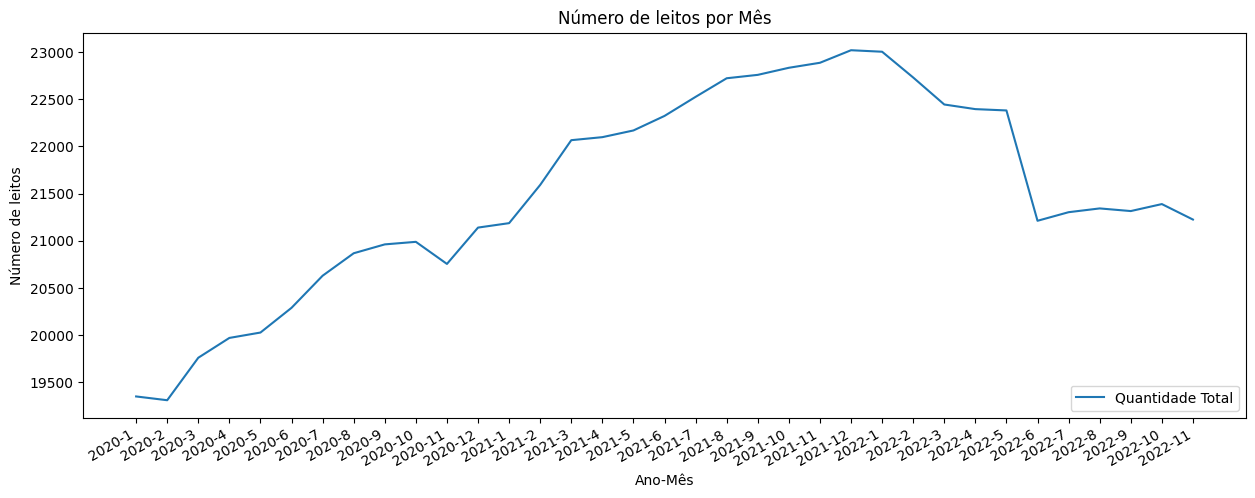

In [7]:
# Eixo X com as datas 
date = df_leitos['Data']

# Eixo Y com as quantidades
qtd_total = df_leitos['QTD Total']

# Plotando os dados
plt.figure(figsize=(15, 5))
plt.plot(date, qtd_total, label="Quantidade Total")

# Legenda para a linha
plt.legend(loc="lower right")

# Título do gráfico
plt.title('Número de leitos por Mês')

# Rotacionando os labels do eixo X para facilitar a leitura
plt.xticks(rotation=30, ha='right')

# Legenda para os eixos
plt.xlabel('Ano-Mês')
plt.ylabel('Número de leitos')

Text(0, 0.5, 'Número de leitos')

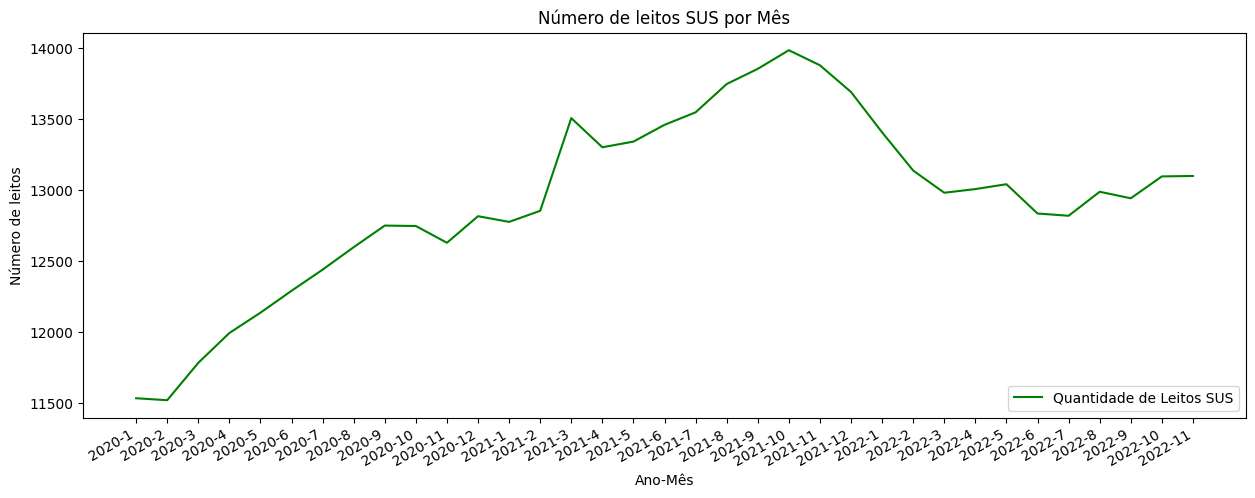

In [8]:
# Eixo X com as datas 
date = df_leitos['Data']

# Eixo Y com as quantidades
qtd_sus = df_leitos['QTD SUS']

# Plotando os dados
plt.figure(figsize=(15, 5))
plt.plot(date, qtd_sus, color='green', label="Quantidade de Leitos SUS")

# Legenda para a linha
plt.legend(loc="lower right")

# Título do gráfico
plt.title('Número de leitos SUS por Mês')

# Rotacionando os labels do eixo X para facilitar a leitura
plt.xticks(rotation=30, ha='right')

# Legenda para os eixos
plt.xlabel('Ano-Mês')
plt.ylabel('Número de leitos')

Text(0, 0.5, 'Número de leitos')

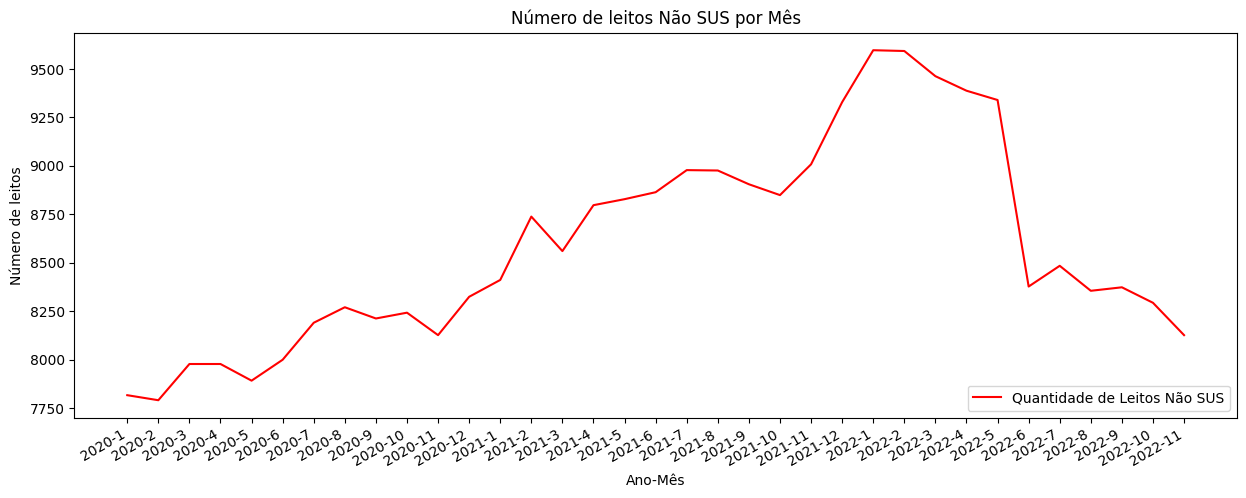

In [9]:
# Eixo X com as datas 
date = df_leitos['Data']

# Eixo Y com as quantidades
qtd_nsus = df_leitos['QTD Não SUS']

# Plotando os dados
plt.figure(figsize=(15, 5))
plt.plot(date, qtd_nsus, color='red', label="Quantidade de Leitos Não SUS")

# Legenda para a linha
plt.legend(loc="lower right")

# Título do gráfico
plt.title('Número de leitos Não SUS por Mês')

# Rotacionando os labels do eixo X para facilitar a leitura
plt.xticks(rotation=30, ha='right')

# Legenda para os eixos
plt.xlabel('Ano-Mês')
plt.ylabel('Número de leitos')

### Declínio na capacidade hospitalar instalada

In [10]:
df_decrescimos

,Data,Valor
0,2020-2,40
1,2020-11,234
2,2022-1,16
3,2022-2,273
4,2022-3,286
5,2022-4,49
6,2022-5,14
7,2022-6,1169
8,2022-9,28
9,2022-11,164


Podemos ver que durante as fases mais críticas da pandemia, antes do início da vacinação (17 de janeiro de 2021), a capacidade hospitalar teve um decréscimo no mês de novembro de 2020.